[AirQo Ugandan Air Quality Forecast Challenge](https://zindi.africa/competitions/airqo-ugandan-air-quality-forecast-challenge)
===========================================
### Modelos XGBoost con H2o en R

[Edimer David Jaramillo ](https://edimer.github.io/)  
Abril de 2020

## Instalación de H2o y carga de bibliotecas

## Cargando datos

In [0]:
load("/content/df_acha_train.Rdata")
load("/content/df_acha_test.Rdata")

## Distribución de variable respuesta

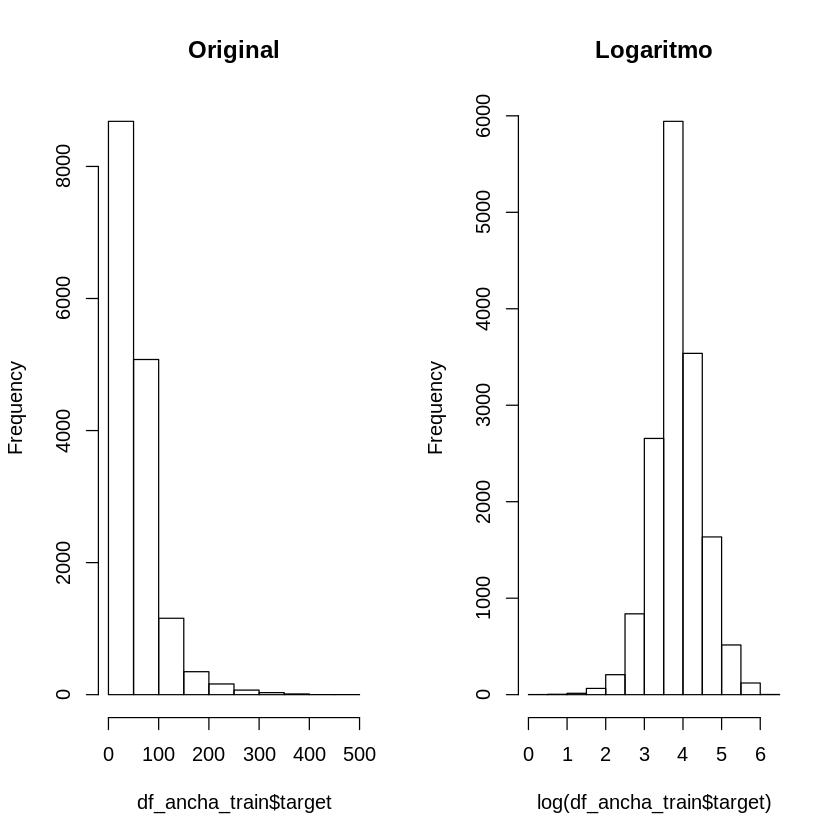

In [13]:
par(mfrow = c(1, 2))
hist(df_ancha_train$target, main = "Original")
hist(log(df_ancha_train$target), main = "Logaritmo")

## Preparación de datos

In [0]:
# Iniciando h2o
h2o.init(nthreads = -1, port = 54321, max_mem_size = "10g")

# df_train y df_test
df_train <- df_ancha_train %>% 
  select(-ID) %>%
  mutate(target = log(target))

datos_h2o <- as.h2o(x = df_train, destination_frame = "datos_h2o")
particiones <- h2o.splitFrame(data = datos_h2o, ratios = c(0.8, 0.10),
                              seed = 123)
datos_train_h2o <- h2o.assign(data = particiones[[1]], key = "datos_train_h2o")
datos_val_h2o   <- h2o.assign(data = particiones[[2]], key = "datos_val_h2o")
datos_test_h2o  <- h2o.assign(data = particiones[[3]], key = "datos_test_h2o")

# Variable respuesta y predictores
var_respuesta <- "target"
predictores   <- setdiff(h2o.colnames(datos_train_h2o), var_respuesta)

## Modelo XGBoost

In [15]:
xgb <- h2o.xgboost(
                  # General
                  ,x = predictores
                  ,y = var_respuesta
                  ,training_frame = datos_train_h2o
                  ,validation_frame = datos_val_h2o
                  ,model_id = "xgb3"  
                  ,stopping_metric = "RMSE"
                  ,distribution = "gaussian"

                  # Learning                
                  ,learn_rate=0.01
                  ,ntrees=20000
                  ,verbose = 1
                  ,stopping_rounds = 50
                  ,max_leaves = 100
                  ,sample_rate = 0.8
                  ,col_sample_rate_per_tree = 0.9
                  ,gamma = 5
                  ,min_rows = 10,
                  ,max_depth = 0
                  ,max_bins = 100
                  ,tree_method = "hist"
                  ,grow_policy = "lossguide"
                  ,booster = "gbtree"

                  # Cross validation
                  ,nfolds = 10
                  ,seed = 123
                  ,max_runtime_secs = 3600)

Se han truncado las últimas 5000 líneas del flujo de salida.
Scoring History for Model xgb3 at 2020-04-16 02:13:45
[1] "Model Build is 46.731168% done..."

Scoring History for Model xgb3 at 2020-04-16 02:13:46
[1] "Model Build is 46.759638% done..."

Scoring History for Model xgb3 at 2020-04-16 02:13:47
[1] "Model Build is 46.788168% done..."

Scoring History for Model xgb3 at 2020-04-16 02:13:48
[1] "Model Build is 46.816695% done..."

Scoring History for Model xgb3 at 2020-04-16 02:13:49
[1] "Model Build is 46.84525% done..."

Scoring History for Model xgb3 at 2020-04-16 02:13:50
[1] "Model Build is 46.87372% done..."

Scoring History for Model xgb3 at 2020-04-16 02:13:51
[1] "Model Build is 46.902665% done..."

Scoring History for Model xgb3 at 2020-04-16 02:13:52
[1] "Model Build is 46.931112% done..."

Scoring History for Model xgb3 at 2020-04-16 02:13:53
[1] "Model Build is 46.959555% done..."

Scoring History for Model xgb3 at 2020-04-16 02:13:54
[1] "Model Build is 46.987972% d

## Resultados del modelo XGBoost

In [16]:
xgb

Model Details:

H2ORegressionModel: xgboost
Model ID:  xgb3 
Model Summary: 
  number_of_trees
1            1075


H2ORegressionMetrics: xgboost
** Reported on training data. **

MSE:  0.1481583
RMSE:  0.3849134
MAE:  0.296668
RMSLE:  0.08293255
Mean Residual Deviance :  0.1481583


H2ORegressionMetrics: xgboost
** Reported on validation data. **

MSE:  0.1852233
RMSE:  0.4303758
MAE:  0.3297386
RMSLE:  0.09226328
Mean Residual Deviance :  0.1852233


H2ORegressionMetrics: xgboost
** Reported on cross-validation data. **
** 10-fold cross-validation on training data (Metrics computed for combined holdout predictions) **

MSE:  0.1986076
RMSE:  0.4456541
MAE:  0.3389443
RMSLE:  0.09688087
Mean Residual Deviance :  0.1986076


Cross-Validation Metrics Summary: 
                             mean           sd cv_1_valid cv_2_valid cv_3_valid
mae                    0.33902034  0.010033957 0.33153352 0.33223778 0.33523142
mean_residual_deviance 0.19867311  0.013221547 0.20171879 0.18565851 0.

## Predicciones

In [20]:
# Train
predichos_train <- h2o.predict(xgb, datos_train_h2o) %>%
  as.data.frame() %>% pull(predict) %>% exp()

# Test (Train)
predichos_test <- h2o.predict(xgb, datos_test_h2o) %>%
  as.data.frame() %>% pull(predict) %>% exp()

# Test (Submission)
predichos_subm <- h2o.predict(xgb, as.h2o(df_ancha_test)) %>%
  as.data.frame() %>% pull(predict) %>% exp()

df_ancha_test %>% 
  select(ID) %>% 
  mutate(target = predichos_subm) ->
  subm10

# Exportando predicciones
write.csv(subm10, file = "subm10.csv", row.names = FALSE)

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


## RMSE Train y Test (train)

In [21]:
# Función
RMSE <- function(pred, obs, na.rm = FALSE){
  sqrt(mean((pred - obs)^2, na.rm = na.rm))
}

data.frame(
  data = c("Train", "Test"),
  RMSE = c(RMSE(pred = predichos_train, obs = as.vector(datos_train_h2o$target)),
           RMSE(pred = predichos_test, obs = as.vector(datos_test_h2o$target)))
)

data,RMSE
<fct>,<dbl>
Train,53.29985
Test,52.92946


## Importancia de variables

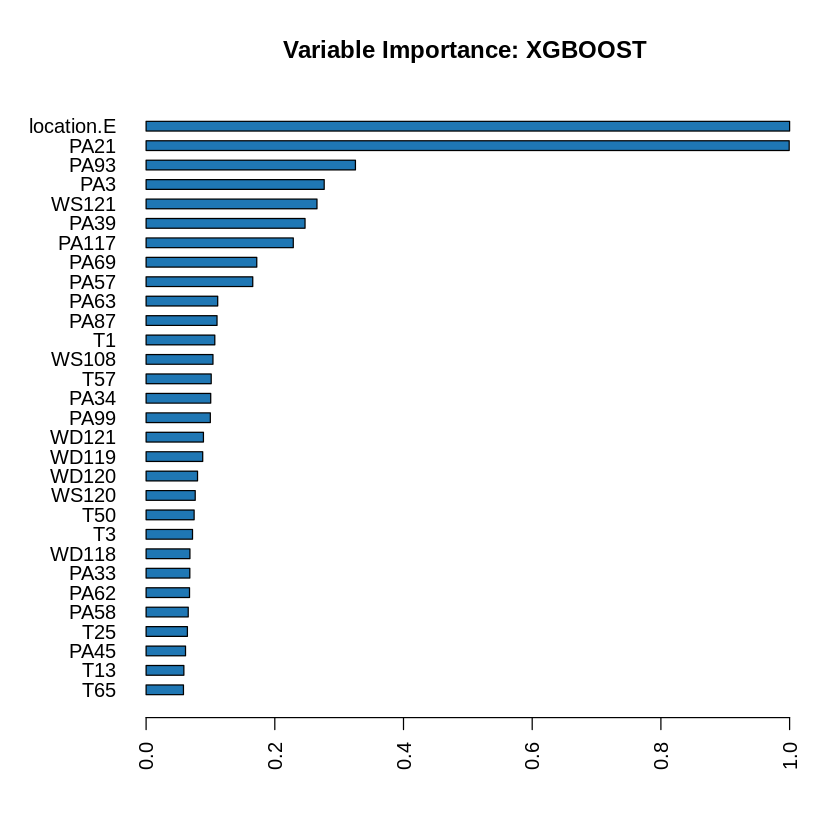

In [22]:
h2o.varimp_plot(xgb, num_of_features = 30)

## Guardando modelo

In [0]:
h2o.saveModel(xgb, path = "XGB_S8", force = TRUE)